No way to plot the decision trees... :(

In [1]:
import pandas as pd
import os

DATA="/Users/aguang/CORE/tippingpoint/tippingpoint/data"
df_dv = pd.read_csv(os.path.join(DATA,"df_dv.dat"))
df_gc = pd.read_csv(os.path.join(DATA,"df_gc.dat"))
df_subject = pd.read_csv(os.path.join(DATA,"df_subject.dat"))
full_df = pd.read_csv(os.path.join(DATA,"full_df.dat"))

In [2]:
dropped = full_df.drop(columns=["impChange","impRise","impFall","impPeriodic","liwcCause","liwcFocusPre","liwcFocusFut","liwcRelativ","liwcTime"]).dropna()

In [3]:
feature_cols = ["risingBefore", "cannotSeeAfter", "downOverall", "bellOverall", "complexOverall", "expExec", "liwcPosemo", "liwcNegemo"]

In [4]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(dropped[feature_cols],dropped.tp)

In [5]:
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

def decision_tree_image(decision_tree, file=None):
    dot_data = StringIO()
    tree.export_graphviz(decision_tree,out_file=dot_data,filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    if file:
        graph.write_png(file)
    img = Image(graph.create_png())
    return(img)

In [6]:


dot_data = StringIO()
tree.export_graphviz(clf,out_file=dot_data,filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("decisiontree.png")
img = Image(graph.create_png())

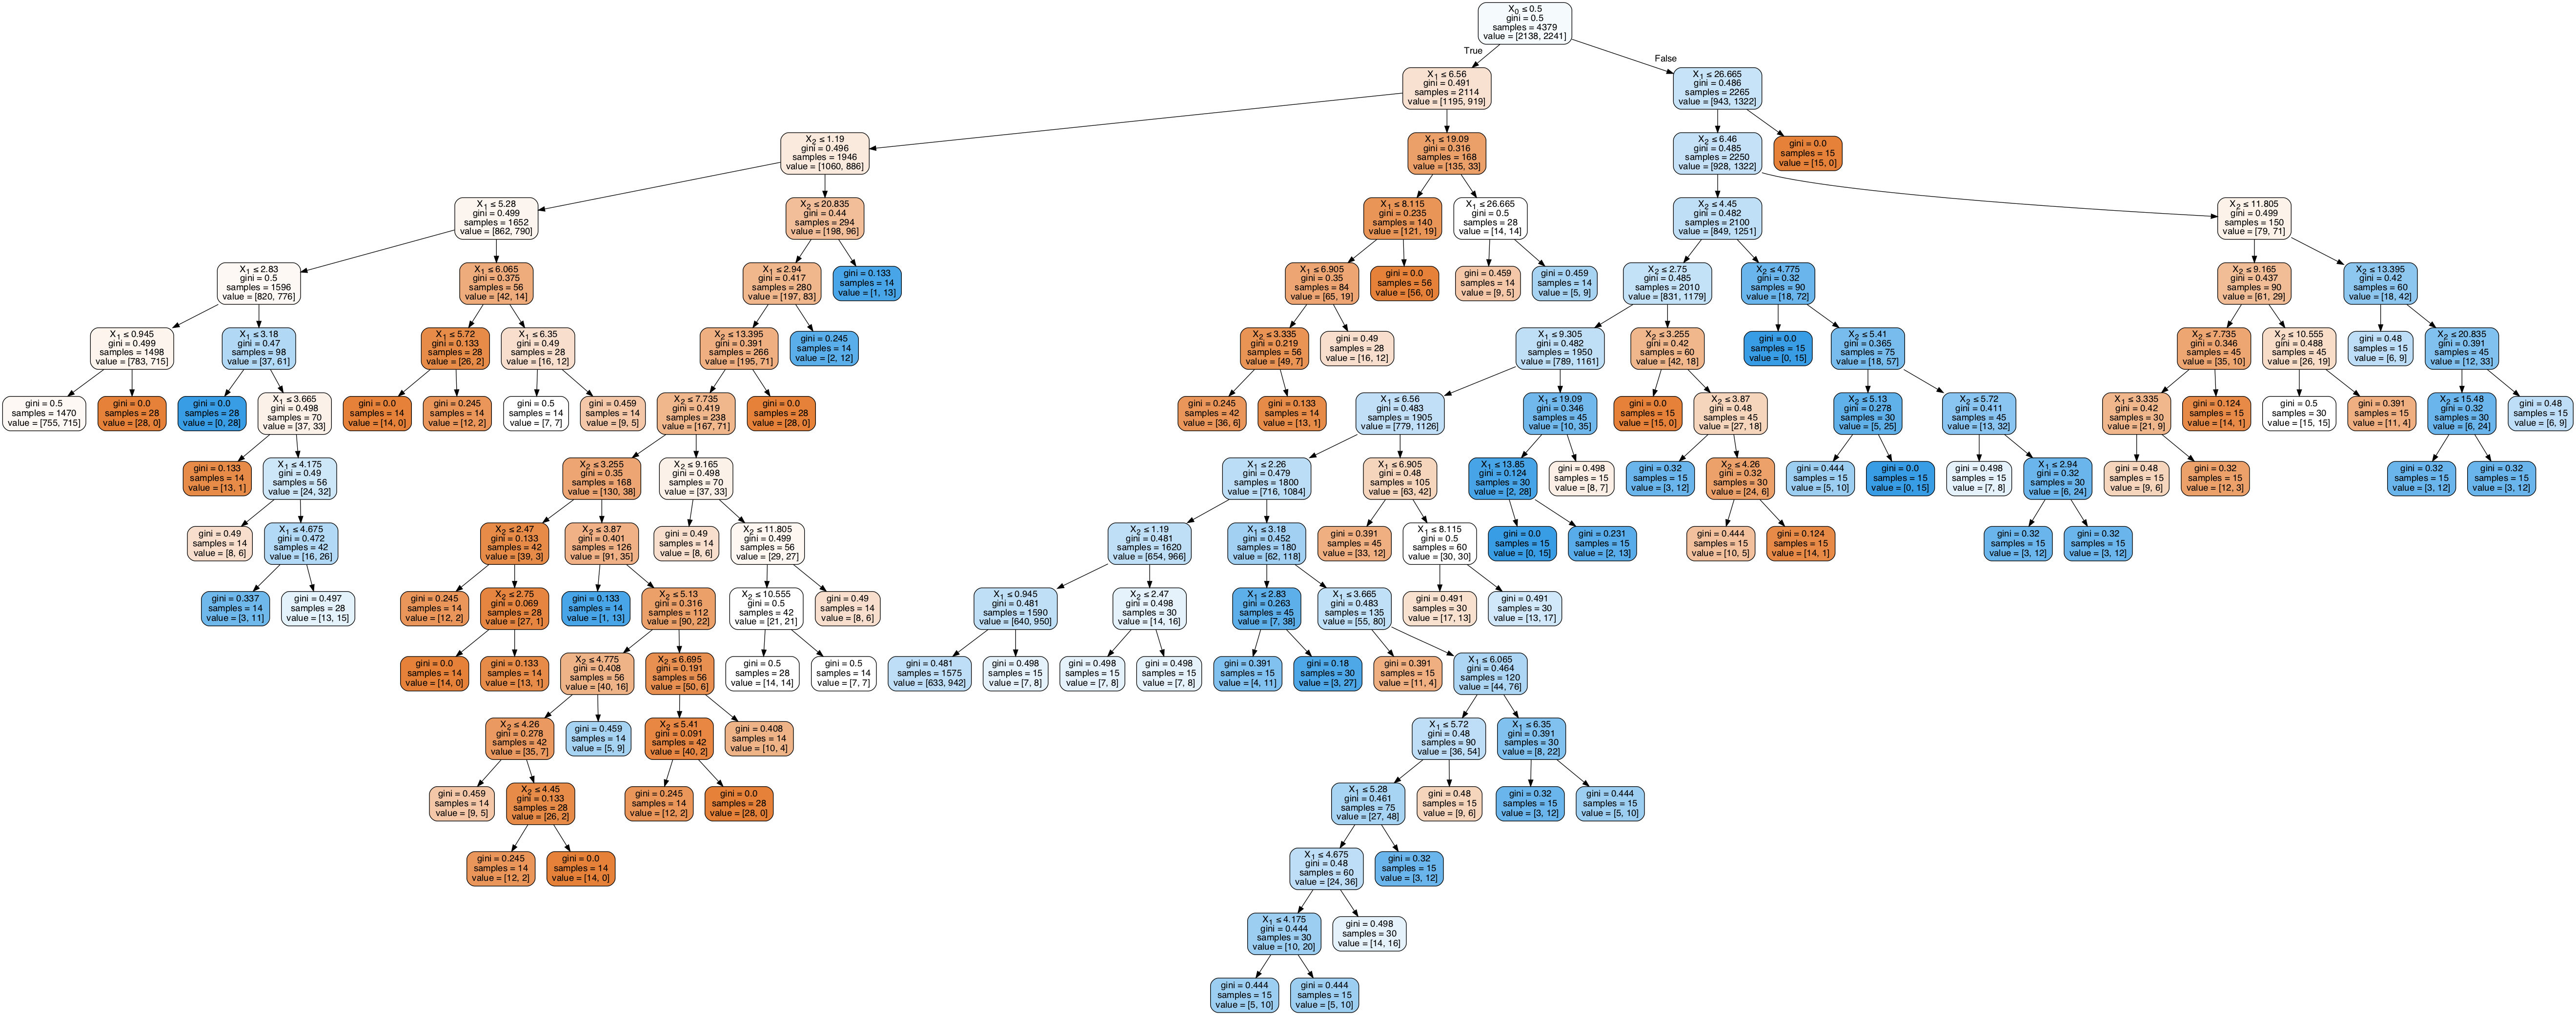

In [7]:
feature_cols2 = ["risingBefore", "liwcPosemo", "liwcNegemo"]
clf2 = tree.DecisionTreeClassifier()
clf2 = clf2.fit(dropped[feature_cols2],dropped.tp)
decision_tree_image(clf2)